<a href="https://colab.research.google.com/github/prudhvi144/CNTK/blob/master/Copy_of_CS591pset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS591 Homework 1
In this homework assignment we will be investigating the effect of different metric learning methods on a multimodal task.  The questions for this assignment are at the end of this notebook.  You are expected to generate a pdf as well as submit your code.

For this assignment we are using [Pytorch](https://pytorch.org/), but you can use a different framework if you would prefer.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)

1.7.1+cu101


## Sentences 3D dataset
For this homework assignment we will be investing a problem that relates images, language, and depth information.  Each rgb-d image is described by one or more sentences.  Each noun in the sentences has its location annotated in the image.  You can browse some examples [here](http://www.cs.toronto.edu/~fidler/projects/sentences3Ddataset_1.html).

The task we will be solving is matching the annotated image regions to the phrases.  At test time we can assume we have annotations that match phrases to regions, i.e., this is a supervised learning task.  The first step is to download the required datasets.  This may need to be redone every time you connect to a colab instance.

In [ ]:
!wget http://www.cs.toronto.edu/~fidler/data/sentencesNYU.zip

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dzQsK3QlWgp_MeTFYt-zUMCizpvZxASQ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1dzQsK3QlWgp_MeTFYt-zUMCizpvZxASQ" -O nyu_depth.zip && rm -rf /tmp/cookies.txt

import zipfile

with zipfile.ZipFile('sentencesNYU.zip', 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile('nyu_depth.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

--2021-03-05 04:19:45--  http://www.cs.toronto.edu/~fidler/data/sentencesNYU.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86035342 (82M) [application/zip]
Saving to: ‘sentencesNYU.zip.1’

sentencesNYU.zip.1  100%[===================>]  82.05M  14.9MB/s    in 6.6s    

2021-03-05 04:19:51 (12.4 MB/s) - ‘sentencesNYU.zip.1’ saved [86035342/86035342]

--2021-03-05 04:19:52--  https://docs.google.com/uc?export=download&confirm=LKud&id=1dzQsK3QlWgp_MeTFYt-zUMCizpvZxASQ
Resolving docs.google.com (docs.google.com)... 172.217.164.142, 2607:f8b0:4004:815::200e
Connecting to docs.google.com (docs.google.com)|172.217.164.142|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-7k-docs.googleusercontent.com/docs/securesc/4h38g4s11ekgkk0kkhoc95djs8q7ns0k/5ti7sh15rfhg5i0fgmh6gtjqkqevib

In [ ]:
import os, re, scipy.io
import numpy as np
from collections import Counter
from PIL import Image

data_path = 'data'
class DatasetLoader(torch.utils.data.Dataset):
    """ Dataset loader class that loads feature matrices from given paths and
        create shuffled batch for training, unshuffled batch for evaluation.
    """
    def __init__(self, split='train', vocab=None, transform=None):
      self.transform = transform
      if split == 'train':
        im_ids = [str(im_id+1).zfill(4) for im_id in range(1049)]
      elif split == 'test':
        im_ids = [str(im_id+1).zfill(4) for im_id in range(1049, 1249)]
      else:
        im_ids = [str(im_id+1).zfill(4) for im_id in range(1249, 1449)]
      
      annos = []
      all_words = Counter()
      for im_id in im_ids:
        f_gt = scipy.io.loadmat(os.path.join(data_path, "descriptions_gt", 'gt' + im_id + ".mat"))
        f = scipy.io.loadmat(os.path.join(data_path, "descriptions", im_id + ".mat"))
        bboxes = f['annotation']['bboxes'][0][0]
        inds = f['annotation']['descriptions'][0][0][0][0][-1]
        words = f_gt['noun'][0]
        phrases_seen = set()
        for word, ind in zip(words, inds):
          if not ind:
              continue

          phrase = [str(w[0][0]) for w in word['adj'][0][0]]
          phrase.append(str(word['word'][0][0][0]))
          if split != 'train':
            p = ' '.join(phrase)
            if p in phrases_seen:
              continue

            phrases_seen.add(p)

          ind = str(ind[0][0]).split(',')
          if len(ind) == 1:
            if ind[0] in ['q','q8','2-']:
              continue

            ind = ind[0].split()
      
          tmp = [int(i)-1 for i in ind if i and ':' not in i]
          for i in ind:
            if ':' in i:
              start, end = i.split(':')
              tmp += list(range(int(start), int(end)))

          ind = tmp
          boxes = np.array(bboxes[ind], np.int)
          boxes[:, 2] += boxes[:, 0]
          boxes[:, 3] += boxes[:, 1]
          gt_box = [min(boxes[:, 0]), min(boxes[:, 1]), max(boxes[:, 2]), max(boxes[:, 3])]
          annos.append((im_id, gt_box, phrase))
          all_words.update(phrase)
                           
      if split == 'train':
        vocab = [word for word, cnt in all_words.most_common() if cnt >= 3]
        vocab = dict(zip(vocab, range(1, len(vocab) + 1)))
        self.vocab = vocab
        print('Vocab Size: ', len(vocab), 'Number of filtered words: ', len(all_words) - len(vocab))

      self.annos = []
      for im_id, gt_box, phrase in annos:
        inds = [vocab[word] for word in phrase if word in vocab]
        self.annos.append((im_id, gt_box, inds))

      self.im_ids = im_ids

    def __len__(self):
      return len(self.annos)

    def load_image(self, fn, gt_box):
      image = Image.open(fn).convert("RGB").crop(gt_box)
      if self.transform:
          image = self.transform(image)

      return image

    def __getitem__(self, index):
      im_id, gt_box, inds = self.annos[index]
      depth_image = self.load_image(os.path.join(data_path, 'depth', im_id + '.jpg'), gt_box)
      rgb_image = self.load_image(os.path.join(data_path, 'images', im_id + '.jpg'), gt_box)
      phrases = np.zeros(2, np.int64)
      phrases[:len(inds)] = inds
      return rgb_image, depth_image, phrases

BATCH_SIZE = 12



## transformations
transform = transforms.Compose(
    [transforms.Resize([128, 128]),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

## download and load training dataset
trainloader = torch.utils.data.DataLoader(DatasetLoader(transform=transform), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
vocab = trainloader.dataset.vocab
testloader = torch.utils.data.DataLoader(DatasetLoader('test', vocab, transform), batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)
valloader = torch.utils.data.DataLoader(DatasetLoader('val', vocab, transform), batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Vocab Size:  337 Number of filtered words:  673


## Looking at the data
The data loader is setup to return cropped image regions, their corresponding depth map, and indices for each word in the vocabularly.  The vocabularly is automatically built based off of words in the training set that occur at least three times. This means that there are a number of words that we won't support at test time.  For a threshold of requiring at least three occurrences of words it means that 676 out of 1100 words are actually filtered.  This exemplifies the very long-tailed distribution of words that occurs in language. You may want to test different thresholds to see its effect on performance.

Below we can see the output of some of the images regions and their corresponding depth maps.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


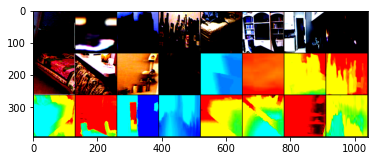

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, depth, _ = dataiter.next()
images = torch.cat((images, depth), 0)
## show images
imshow(torchvision.utils.make_grid(images))

## Defining the model
Below we have a baseline model that uses a pretrained ResNet18 model to encode the image regions.  It represents each word as a 128 dimensional vector that it trains from scratch along with a two-layer perceptron to project it into the same dimensions as the visual features.

You could test different similarity functions to help improve performance. You will notice that the depth information isn't being used in the current model, and you will be asked to develop a new approach for integrating it in the model.

In [ ]:
import torchvision.models as models

def image_forward(model, proj, x):
  x = model(x).view(len(x), -1)
  return proj(x)

class MultimodalModel(nn.Module):
    def __init__(self, vocab_length):
        super(MultimodalModel, self).__init__()

        # image encoder
        model = models.resnet18(pretrained=True)

        feature_size = 64
        # remove the final fully connected layer
        self.cnn = torch.nn.Sequential(*(list(model.children())[:-1]))
        self.image_proj = nn.Linear(512, feature_size)

        word_embedding_size = 128
        self.word_features = torch.nn.Embedding(vocab_length, word_embedding_size)
        
        latent_size = 256
        self.phrase_mlp = nn.Sequential(nn.Linear(word_embedding_size, latent_size),
                              nn.BatchNorm1d(latent_size),
                              nn.ReLU(inplace=True),
                              nn.Dropout(p=0.5),
                              nn.Linear(latent_size, feature_size))
        
    def encode_phrases(self, tokens):
      # the tokens are indices that will identify the embedding
      # corresponding to a word.  In this codebase we assume index "0"
      # represents a padding token (i.e., it doesn't correspond to an 
      # individual word)
      words = self.word_features(tokens)

      # after getting each word embedding, we represent the entire phrase
      # by taking the average
      eps = torch.finfo(torch.float32).eps
      n_words = torch.sum(tokens > 0, 1).float() + eps
      sum_words = words.sum(1).squeeze()
      phrases = F.normalize(sum_words / n_words.unsqueeze(1))

      # now that we have the phrase features we will pass it through the MLP
      phrases = self.phrase_mlp(phrases)
      return phrases

    def similarity(self, x, y, test=False):
      # L2 normalzing features can make training more stable
      x, y = F.normalize(x), F.normalize(y)

      # We'll build a similarity matrix over all cross-modal pairs
      sim = x.mm(y.t())
      if test:
        # the testing code wants the index of the best match
        _, sim = sim.max(0)

      return sim

    def forward(self, image, depth, words):
      image = image_forward(self.cnn, self.image_proj, image)
      # image = F.softmax(image)
      image =  nn.Softmax(dim=1)(image)
      words = self.encode_phrases(words)
      return image, words

## Training Setup
Here we setup the optimizer, learning rate, and number of epochs.  Feel free to change these if you wish.

In [ ]:
learning_rate = 0.0001
num_epochs = 25

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultimodalModel(len(vocab) + 1)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## compute accuracy
def test_model(model, dataloader):
    image_features, phrase_features = [], []
    for images, depth, phrases in dataloader:
      images = images.to(device)
      depth = depth.to(device)
      phrases = phrases.to(device)
      im_out, phrases_out = model(images, depth, phrases)
      image_features.append(im_out.data)
      phrase_features.append(phrases_out.data)

    image_features, phrase_features = torch.cat(image_features), torch.cat(phrase_features)
    last_im = None
    num_correct, num_total = 0., 0.
    for (im_id, _, _), im_feat, p_feat in zip(dataloader.dataset.annos, image_features, phrase_features):
      if last_im is not None and last_im != im_id:
        x, y = torch.stack(x), torch.stack(y)
        indices = model.similarity(x, y, test=True)
        gt = torch.arange(len(indices)).to(device)
        num_correct += (indices == gt).sum()
        num_total += len(indices)

      if last_im is None or last_im != im_id:
        x, y = [], []

      x.append(im_feat)
      y.append(p_feat)      

      last_im = im_id
    
    accuracy = 100.0 * num_correct/num_total
    return accuracy.item()

In [ ]:
n=10
temp = torch.tensor(list(range(1,n*n+1))).reshape(n,n)

# print (temp.diag())

t_out = temp.flatten()[1:].view(n-1, n+1)[:,:-1].reshape(n, n-1)

# print(print(temp.flatten()[1:]))
# print(temp.flatten()[1:].view(n-1, n+1))
# print(temp.flatten()[1:].view(n-1, n+1)[:,:-1])

# print(t_out)

print(temp)

rand_int = torch.randint(0,BATCH_SIZE , (3,))
# skfjjv = t_out[:,rand_int]
valid_idx  = ( torch.mul( ( temp < 20),  (temp <50))).nonzero()
print(valid_idx)
unique_rows = valid_idx[:, 0].unique()

print ("unique_rows",unique_rows)
valid_row_idx = [valid_idx[valid_idx[:, 0] == u] for u in unique_rows]
ret = []
for v in valid_row_idx:
    choice = torch.multinomial(torch.arange(v.size(0)).float(), 1)
    ret.append(temp[v[choice].squeeze().chunk(2)])
ret = torch.stack(ret).flatten()

print (ret)



tensor([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10],
        [ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20],
        [ 21,  22,  23,  24,  25,  26,  27,  28,  29,  30],
        [ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40],
        [ 41,  42,  43,  44,  45,  46,  47,  48,  49,  50],
        [ 51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
        [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70],
        [ 71,  72,  73,  74,  75,  76,  77,  78,  79,  80],
        [ 81,  82,  83,  84,  85,  86,  87,  88,  89,  90],
        [ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100]])
tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [0, 5],
        [0, 6],
        [0, 7],
        [0, 8],
        [0, 9],
        [1, 0],
        [1, 1],
        [1, 2],
        [1, 3],
        [1, 4],
        [1, 5],
        [1, 6],
        [1, 7],
        [1, 8]])
unique_rows tensor([0, 1])
tensor([ 3, 13])


Triplet Loss

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    model = model.train()

    ## training step
    for i, (images, depth, phrases) in enumerate(trainloader):
        if len(images) == 1:
          continue

        images = images.to(device)
        depth = depth.to(device)
        phrases = phrases.to(device)


        im_out, phrases_out = model(images, depth, phrases)
        sim = model.similarity(im_out, phrases_out)
        pos = sim.diag()
        # print(im_out[0])
        neg  = temp.flatten()[1:].view(BATCH_SIZE-1, BATCH_SIZE+1)[:,:-1].reshape(BATCH_SIZE, BATCH_SIZE-1)
        
        break
    break


RuntimeError: ignored

Training loop

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    model = model.train()

    ## training step
    for i, (images, depth, phrases) in enumerate(trainloader):
        if len(images) == 1:
          continue

        images = images.to(device)
        depth = depth.to(device)
        phrases = phrases.to(device)


        im_out, phrases_out = model(images, depth, phrases)
        sim = model.similarity(im_out, phrases_out)

        # this simple loss just tries to make similarity scores of the positive
        # image region-phrase pairs small
        
        
        pos = sim.diag()
        neg = sim.flatten()[1:].view(BATCH_SIZE-1, BATCH_SIZE+1)[:,:-1].reshape(BATCH_SIZE, BATCH_SIZE-1)

        
        valid_idx = (neg <1000).nonzero()
        unique_rows = valid_idx[:, 0].unique()

        
        valid_row_idx = [valid_idx[valid_idx[:, 0] == u] for u in unique_rows]
        ret = []
        for v in valid_row_idx:
            choice = torch.multinomial(torch.arange(v.size(0)).float(), 1)
            ret.append(neg[v[choice].squeeze().chunk(2)])
        ret = torch.stack(ret).flatten()
     

        
        loss =  ((1 + ret - (sim.diag())).clamp(min=0)).mean()

        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
  
    model.eval()
    val_acc = test_model(model, valloader)
    print('Epoch: %d | Loss: %.4f | Val Accuracy: %.2f' \
          %(epoch, train_running_loss / i, val_acc))

test_acc = test_model(model, testloader)
print('Test Accuracy: %.2f'%(test_acc))       

Epoch: 0 | Loss: 0.9208 | Val Accuracy: 39.55
Epoch: 1 | Loss: 0.7728 | Val Accuracy: 41.06
Epoch: 2 | Loss: 0.6725 | Val Accuracy: 42.67
Epoch: 3 | Loss: 0.6107 | Val Accuracy: 46.55
Epoch: 4 | Loss: 0.5619 | Val Accuracy: 44.18
Epoch: 5 | Loss: 0.5284 | Val Accuracy: 47.78
Epoch: 6 | Loss: 0.4984 | Val Accuracy: 43.71
Epoch: 7 | Loss: 0.4664 | Val Accuracy: 47.11
Epoch: 8 | Loss: 0.4417 | Val Accuracy: 47.21
Epoch: 9 | Loss: 0.4383 | Val Accuracy: 46.93
Epoch: 10 | Loss: 0.4131 | Val Accuracy: 46.07
Epoch: 11 | Loss: 0.3963 | Val Accuracy: 47.78
Epoch: 12 | Loss: 0.3766 | Val Accuracy: 45.22
Epoch: 13 | Loss: 0.3724 | Val Accuracy: 48.16
Epoch: 14 | Loss: 0.3570 | Val Accuracy: 47.87
Epoch: 15 | Loss: 0.3388 | Val Accuracy: 47.78
Epoch: 16 | Loss: 0.3337 | Val Accuracy: 48.16
Epoch: 17 | Loss: 0.3328 | Val Accuracy: 48.72
Epoch: 18 | Loss: 0.3188 | Val Accuracy: 49.39
Epoch: 19 | Loss: 0.3105 | Val Accuracy: 50.14
Epoch: 20 | Loss: 0.3132 | Val Accuracy: 48.82
Epoch: 21 | Loss: 0.301

# Questions (100 points possible)
This assignment is out of 100 points.  The student who reports the best performance on this task using a ResNet18 model will recieve 5 points extra credit.

## Part 1: Sampling method comparison (20 points)

The loss function used in this problem is very simple and doesn't even use any negative samples.  Begin by replacing it with a triplet loss, and then explore the effect of different methods of sampling negatives.  In particular, provided a comparison between

1. Triplet loss (no modifications)
2. Top-K hard negatives (include description of how you selected "K")
3. Semi-hard negatives
4. Optional (10 points extra credit), Distanced-weighted sampling or other more complex sampling method

## Part 2: Selecting a loss function (15 points)

Now that we have an idea of how well the triplet loss can do, let's compare to other popular loss functions.  In particular, compare the triplet loss with a contrastive loss and a normalized temperature-scaled cross entropy loss.  Report the performance of each loss, as well as how you tuned any associated hyperparameters.

## Part 3: Effectively increasing the batch size (25 points)

Implement either proxies or a memory module to provide additional negative samples during training.  Along with reporting the results on the test set, also include a description what you used these methods to represent, and why this was a good choice.

## Part 4: Incorporating depth information (30 points)

Unlike many of the examples we discussed in class that only dealt with two modalities, in this dataset we have a third modality not used in the inital model: depth information.  In this problem you are tasked with trying to use this data to improve your task performance.  You can use a strategy we discussed in class (e.g. the 05 Metric Learning IV Brainstorming session), or come up with a new approach.

As with the other problems, you are expected to not only provide the final results comparing your new model using depth with your model without depth, but also a motivation for selecting your approach.

## Part 5: Conclusions (10 points)

Write a brief summary of your experiments (no more than 3 paragraphs).  For things that didn't work, try to give insight into why not, and what could be done to improve it (or point to a different experiment you did that does already improve on it).  Propose at least one potential approach that could further help improve performance on this task.